In [1]:
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import math

import torch
from torch.utils.data import Dataset

import heartpy as hp
from heartpy.exceptions import BadSignalWarning
from heartpy.datautils import rolling_mean
from heartpy.peakdetection import detect_peaks, fit_peaks, calc_rr

from numpy.lib.stride_tricks import as_strided

import config

from elgendi_ppg_peak_detection import elegendi_ppg_findpeaks

RR_WINDOW_SIZE = 60

FS = 128
DFS = 50

AF = 1
NON_AF = 0

LOW_FREQ_FILTER = (30 / 60)
HI_FREQ_FILTER = (240 / 60)

print(f'Bandpass filter frequencies: [ {LOW_FREQ_FILTER}, {HI_FREQ_FILTER} ]')

Bandpass filter frequencies: [ 0.5, 4.0 ]


In [7]:
class PPGDataset(Dataset):
    def __init__(self, data_path, freq, peak_detector='heartpy'):
        self.freq = freq
        self.data_path = data_path
        data_files = os.listdir(data_path)
        self.peak_detector = peak_detector
        if peak_detector not in ['heartpy', 'elgendi']:
            self.peak_detector = 'heartpy'

        # File discovery
        self.subjects = {f[:4] for f in data_files if f[:4].isdigit()}
        self.signal_files = [os.path.join(data_path, s + '.mat') for s in self.subjects]
        self.ground_truth_files = [os.path.join(data_path, s + '_ground_truth.mat') for s in self.subjects]

        # self.ground_truth_files = [f for f in data_files if 'ground_truth' in f]
        # self.peak_ref_files = [f for f in data_files if 'Peak_Ref_ECG' in f]
        # self.ecg_30_sec_files = [f for f in data_files if 'ECG_30sec' in f]
        # self.ref_ecg_files = [f for f in data_files if 'RefECG' in f]

        self.info_file = None
        if 'UMass_SimbandInfo.mat' in data_files:
            self.info_file = os.path.join(data_path, 'UMass_SimbandInfo.mat')

        # self.signal_files = set(data_files) - set(self.ground_truth_files + self.peak_ref_files + self.ecg_30_sec_files + self.ref_ecg_files + [self.info_file])
        # self.signal_files = list(self.signal_files)
        # print('signal_files:', self.signal_files)
        # self.subjects = [int(os.path.splitext(x)[0]) for x in self.signal_files]
        # self.subjects.sort()

        self.cache = {}
        self.data = []
        self.rr_intervals = []

    # def get_raw_ppg_signal(self, pid, channel=0):
    #     signal_file = os.path.join(self.data_path, f'{pid}.mat')
    #     _data = scipy.io.loadmat(signal_file, matlab_compatible=True, simplify_cells=True)
    #     if channel not in range(8):
    #         channel = 0
    #     return _data['data']['physiosignal']['ppg'][chr(ord('a') + channel)]['signal']

    def bandpass_filter(self, x, filter_order=2):
        return hp.filter_signal(x, [config.LOW_FREQ_FILTER, config.HI_FREQ_FILTER], sample_rate=self.freq, order=filter_order, filtertype='bandpass')

    def get_ppg_signal(self, pid, filter=True):
        signal_file = os.path.join(self.data_path, f'{pid}.mat')
        _data = scipy.io.loadmat(signal_file, matlab_compatible=True, simplify_cells=True)
        if filter:
            return self.bandpass_filter(_data['PPG_FULL'])
        return _data['PPG_FULL']

    def get_ground_truth(self, pid):
        gt_file = os.path.join(self.data_path, f'{pid}_ground_truth.mat')
        _data = scipy.io.loadmat(gt_file, matlab_compatible=True, simplify_cells=True)
        _gt = _data['disease_label']
        return (_gt[:,1:] == config.AF).flatten().astype(float)

    def process_signals(self):
        window_size = 30 * self.freq
        sub_window_size = window_size // 3

        for subject in self.subjects:
            sig = self.get_ppg_signal(subject)
            gt = self.get_ground_truth(subject)
            rrs = []
            gts = []
            for i in range(len(gt)):
                window = sig[window_size*i:window_size*(i+1)]
                if self.peak_detector == 'elgendi':
                    try:
                        _peaks = elegendi_ppg_findpeaks(window, sampling_rate=config.DFS, )['PPG_Peaks']
                        rr = calc_rr(_peaks, sample_rate=config.DFS)['RR_list']
                    except:
                        rr = np.array([])
                else:
                    rol_mean = rolling_mean(window, windowsize=1, sample_rate=config.DFS)
                    wd = detect_peaks(window, rol_mean, ma_perc=20, sample_rate=config.DFS)
                    rr = wd['RR_list']
                rrs.append(rr)
                gts.append(np.ones_like(rr) * gt[i])
            
            rrs = np.hstack(rrs)
            gts = np.hstack(gts)

            rrs = as_strided(rrs,shape=(len(rrs)//config.RR_WINDOW_SIZE, config.RR_WINDOW_SIZE))
            gts = as_strided(gts,shape=(len(gts)//config.RR_WINDOW_SIZE, config.RR_WINDOW_SIZE))

            for i in range(rrs.shape[0]):
                # Filtering / Masking ignorance should go here
                self.rr_intervals.append((rrs[i], max(gts[i]), i, subject))

                # for j in range(3):
                #     start_idx = window_size*i + sub_window_size*j
                #     end_idx = start_idx + sub_window_size
                #     self.data.append((sig[start_idx:end_idx], gt[i]))

    def window(self, x, freq, start=0, sec=10):
        start_idx = math.floor(start * freq)
        end_idx = math.floor(start_idx + sec * freq)
        return x[start_idx:end_idx]

    def __len__(self):
        return len(self.rr_intervals)

    def __getitem__(self, idx):
        return self.rr_intervals[idx]


dataset = PPGDataset('data', freq=DFS, peak_detector='elgendi')
dataset.process_signals()

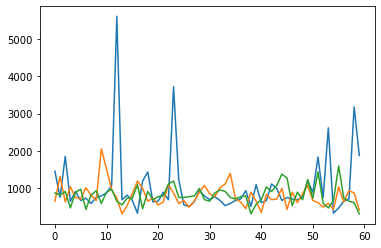

In [8]:
x1 = dataset[0][0]
x2 = dataset[1][0]
x3 = dataset[3][0]

plt.figure()
plt.plot(x1)
plt.plot(x2)
plt.plot(x3)
plt.show()

In [ ]:
x1 = dataset[0][0]
x2 = dataset[1][0]
x3 = dataset[3][0]

plt.figure()
plt.plot(x1)
plt.plot(x2)
plt.plot(x3)
plt.show()

In [ ]:
sig = dataset.get_ppg_signal('4001')
x = sig[100:900]
peaks = elegendi_ppg_findpeaks(x, sampling_rate=config.DFS)['PPG_Peaks']

plt.plot(x)
plt.scatter(peaks, x[peaks], color='red')
plt.show()

In [ ]:
rr1 = calc_rr(peaks, config.DFS)
rr1['RR_list']

In [ ]:
x = dataset[0]
x

In [ ]:
total = 0
af = 0
sigs = []
for subject in dataset.subjects:
    gt = dataset.get_ground_truth(subject)
    total += 1
    if 1 in gt:
        af += 1
    sig = dataset.get_ppg_signal(subject)
    print('Subject ', subject, ' recording duration: {:.2f}'.format(len(sig) / (DFS*60)), 'minutes')
    sigs.append(sig)


print('total=', total)
print('af=', af)

In [ ]:
avg_signal_length = sum([len(x) for x in sigs]) / total
avg_signal_length

In [ ]:
avg_signal_length / (DFS)

In [ ]:
x = dataset.get_ppg_signal(4001, filter=False)
xf = dataset.get_ppg_signal(4001, filter=True)

t1 = 3000
t2 = 3200

plt.figure(figsize=(12,4))
plt.title('Raw PPG signal')
plt.plot(x[t1:t2])
plt.show()

plt.figure(figsize=(12,4))
plt.title('Filtered PPG signal')
plt.plot(xf[t1:t2])
plt.show()

In [ ]:
len(dataset.rr_intervals)

In [ ]:
dataset.rr_intervals[1]

In [ ]:
for i in range(len(dataset)):
    X,y,pid = dataset[i]
    if 1 in y:
        print('found AF for ', pid)
        break

In [ ]:
plt.figure()

t1 = 20
t2 = 300

plt.plot(X[t1:t2])
plt.plot((y*1000)[t1:t2])
plt.show()

In [ ]:
X.shape

In [ ]:
X[:60], X[60:120]

In [ ]:
swid = np.lib.stride_tricks.as_strided(X,shape=(len(X)//60, 60))
swid.shape

In [ ]:
[swid[i,:] for i in range(swid.shape[0])]

In [ ]:
26*60

In [ ]:
swid = np.lib.stride_tricks.sliding_window_view(X, window_shape=(60))

swid[0]

In [ ]:
swid[1]

In [ ]:
wd, measures = hp.process(dataset.data[200][0], sample_rate=DFS, windowsize=1.2)
hp.plotter(wd, measures)

In [ ]:
rmssd = []
bpm = []
for sig, gt in dataset.data:
    try:
        wd, measures = hp.process(sig, sample_rate=DFS, windowsize=1.2)
        rmssd.append(measures['rmssd'])
        bpm.append(measures['bpm'])
    except BadSignalWarning:
        continue

In [ ]:
plt.figure()
plt.title('RMSSD Distribution')
plt.hist(rmssd, bins=20)
plt.xlabel('rmssd')
plt.ylabel('# windows')
plt.show()

In [ ]:
plt.figure()
plt.title('BPM Distribution')
plt.hist(bpm, bins=20)
plt.xlabel('bpm')
plt.ylabel('# windows')
plt.show()

In [ ]:
sig,gt = dataset.data[300]
wd, measures = hp.process(sig, sample_rate=DFS, windowsize=3)
rol_mean = rolling_mean(sig, windowsize = 1, sample_rate = DFS)
wd = detect_peaks(sig, rol_mean, ma_perc = 20, sample_rate = DFS)
wd.keys()

In [ ]:
plt.figure()
plt.plot(dataset.rr_intervals[200][0])
plt.show()